In [ ]:
!pip install category-encoders
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.9 MB/s eta 0:00:00


In [ ]:
# Standard libraries
import os
import re
import shutil
import string
import statistics
import warnings
import itertools
import pickle

# Data manipulation and analysis
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, boxcox, skew, kurtosis, normaltest

# Visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Machine learning - preprocessing and model selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.experimental import enable_iterative_imputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report

# Machine learning - models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, cv, Pool
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Machine learning - metrics
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc,
                             confusion_matrix, classification_report,make_scorer)

# Machine learning - encoders
from category_encoders import TargetEncoder, OrdinalEncoder, CountEncoder

# Machine learning - decomposition
from sklearn.decomposition import PCA

# Set global options
np.set_printoptions(precision=2)
pd.set_option('display.max_columns', 30)
warnings.filterwarnings('ignore')
plt.style.use('ggplot')


In [ ]:
# Define data types for columns
dtypes = dict(
    Month="category",
    Name="category",
    Occupation="category",
    Type_of_Loan="category",
    Credit_History_Age="category",
    Payment_Behaviour="category"
)

try:
    # Update these file paths according to your local dataset location
    train_file_path = "/content/drive/MyDrive/Dataset/train.csv"
    test_file_path = "/content/drive/MyDrive/Dataset/test.csv"

    train_df = pd.read_csv(train_file_path, dtype=dtypes, parse_dates=['Month'])
    test_df = pd.read_csv(test_file_path, dtype=dtypes, parse_dates=['Month'])

    # Add 'is_train' column to distinguish between train and test data
    train_df["is_train"] = True
    test_df["is_train"] = False

    # Concatenate train and test data
    df = pd.concat([train_df, test_df], ignore_index=True)

    # Optional: Check the shape of the combined DataFrame
    # print(combined_df.shape)

except FileNotFoundError as e:
    print(f"Error: {e}")
    # Handle the error as needed, for example: exit the script or log the error


In [ ]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,is_train
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good,True
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good,True
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good,True
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good,True
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good,True


In [ ]:
np.unique(df["Credit_Mix"])

array(['Bad', 'Good', 'Standard', '_'], dtype=object)

In [ ]:
df.drop(["Name", "SSN", "ID", "Occupation"], axis=1, inplace=True, errors="ignore") # Dropping irrelevant columns

## **Looking for unique values in categorical columns**


In [ ]:
def get_unique_values(df):

    # Select categorical columns
    cat_cols = df.select_dtypes(include=['category', 'object']).columns

    # Check if there are no categorical columns
    if len(cat_cols) == 0:
        return pd.DataFrame(columns=["column", "unique", "counts", "len_unique_values", "%_unique_values"])

    # Initialize an empty DataFrame to store results
    data_info = pd.DataFrame()

    for col in cat_cols:
        # Get unique values and their counts
        value_counts = df[col].value_counts()

        # Skip columns with too many unique values
        if len(value_counts) > 5000:
            continue

        # Prepare data for the DataFrame
        data = {
            "column": col,
            "unique": [value_counts.index.tolist()],
            "counts": [value_counts.values.tolist()],
            "len_unique_values": len(value_counts),
            "%_unique_values": [(value_counts / value_counts.sum()).round(2).tolist()]
        }

        # Append to the DataFrame
        data_info = data_info.append(pd.DataFrame(data), ignore_index=True)

    return data_info


In [ ]:
unique_values_df = get_unique_values(df)
unique_values_df.head()

,column,unique,counts,len_unique_values,%_unique_values
0,Month,"[January, February, March, April, May, June, J...","[12500, 12500, 12500, 12500, 12500, 12500, 125...",12,"[0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.0..."
1,Age,"[39, 32, 28, 26, 35, 44, 38, 27, 31, 22, 25, 3...","[4198, 4189, 4173, 4140, 4130, 4116, 4099, 408...",2524,"[0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.0..."
2,Occupation,"[_______, Lawyer, Engineer, Architect, Mechani...","[10500, 9899, 9562, 9550, 9459, 9404, 9403, 93...",16,"[0.07, 0.07, 0.06, 0.06, 0.06, 0.06, 0.06, 0.0..."
3,Num_of_Loan,"[3, 2, 4, 0, 1, 6, 7, 5, -100, 9, 8, 2_, 3_, 4...","[21500, 21423, 20998, 15543, 15112, 11112, 104...",623,"[0.14, 0.14, 0.14, 0.1, 0.1, 0.07, 0.07, 0.07,..."
4,Num_of_Delayed_Payment,"[19, 17, 16, 15, 10, 18, 12, 20, 9, 11, 8, 14,...","[7949, 7806, 7721, 7671, 7670, 7653, 7388, 735...",1058,"[0.06, 0.06, 0.06, 0.05, 0.05, 0.05, 0.05, 0.0..."


## **Data Processing with the DataProcessor Class**


In [ ]:
class DataProcessor:

    def __init__(self, groupby, data_frame):
        self.groupby = groupby
        self.df = data_frame


    def get_month(self, x):
     if not pd.isnull(x):
         year_month = re.findall(r"\d+", x)
         months = (int(year_month[0])*12) + np.int64(year_month[-1])
         return months
     else:
         x

    @staticmethod
    def get_numbers(text):
        digits = re.findall(r'\d+', str(text))
        digits = ','.join(digits)
        return digits

    @staticmethod
    def replace_special_character(text):
        if "NM" in str(text):
            return "No"

        if "payments" in str(text) or "_" not in str(text):
            return text

        clean_text = str(text).replace("_", "")
        return np.nan if clean_text == "nan" else clean_text

    @staticmethod
    def preprocess_text(texts:str) -> tuple[dict, list[list[str]]]:
        dictionary = {}

        tokens = [str(text).lower().replace("and", "").split(",") for text in texts]
        tokens = [[token.strip() for token in token_list if token not in string.punctuation] for token_list in tokens]
        for token_list in tokens:
            for token in token_list:
                if token not in dictionary:
                    size = len(dictionary)
                    dictionary[token] = size
        return (dictionary, ["|".join(words) for words in tokens])


    @staticmethod
    def fill_na(df: pd.DataFrame, groupby=None):
        cat_features = df.select_dtypes(exclude="number").columns.drop(
            ["is_train", "Credit_Score", "Type_of_Loan"])
        num_features = df.select_dtypes(include="number").columns

        df["Type_of_Loan"].fillna("not specified", inplace=True)

        def fill_na_cat(df):
            df[cat_features] = df.groupby(groupby)[cat_features].transform(
                lambda x: x.fillna(x.mode()[0]))
            return df

        def fill_na_num(df):
            df[num_features] = df.groupby(groupby)[num_features].transform(
                lambda x: x.fillna(x.median()))
            return df

        df = fill_na_cat(df)
        df = fill_na_num(df)
        return df


    def preprocess(self):
        self.df['Age'] = self.df.Age.apply(DataProcessor.get_numbers)
        self.df = self.df.applymap(DataProcessor.replace_special_character)
        self.df = self.df.apply(lambda x: pd.to_numeric(x, errors="ignore"))
        self.df["Credit_Mix"] = self.df.groupby(self.groupby)["Credit_Mix"].transform(lambda x: x.replace("", x.mode()[0]))
        self.df["Payment_Behaviour"] = self.df.groupby(self.groupby)["Payment_Behaviour"].transform(
            lambda x: x.replace("!@9#%8" if x.mode()[0] != "@9#%8" else np.nan)
        )
        self.df["Type_of_Loan"] = self.df[["Type_of_Loan"]].apply(lambda x:  DataProcessor.preprocess_text(x.values)[-1])
        self.df["Type_of_Loan"] = self.df["Type_of_Loan"].str.replace(" ", "_").str.replace("|", " ")
        self.df["Credit_History_Age"] = self.df["Credit_History_Age"].apply(lambda x: self.get_month(x))
        self.df["Monthly_Balance"] = pd.to_numeric(self.df.Monthly_Balance, errors="coerce")
        self.df = DataProcessor.fill_na(self.df, "Customer_ID")

        return self.df

In [ ]:
preprocesor = DataProcessor("Customer_ID", df)
data = preprocesor.preprocess()

In [ ]:
# Replacing negative account balances with zero
data.loc[data["Num_Bank_Accounts"] < 0, "Num_Bank_Accounts"] = 0

# Replace "nan" string values in 'Type_of_Loan' column with NaN
data["Type_of_Loan"] = data["Type_of_Loan"].replace("nan", np.nan)

# Replace empty strings in specified columns with NaN for consistency
columns_to_replace_empty = ["Credit_Mix"]
for col in columns_to_replace_empty:
    data[col] = data[col].replace("", np.nan)


## Outlier Removal and Skewness Correction


In [ ]:
class ClipOutliersTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile: float, upper_quantile: float,
                 multiply_by: float = 1.5, replace_with_median: bool = False):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.multiply_by = multiply_by
        self.replace_with_median = replace_with_median
        self.lower_limit = 0
        self.upper_limit = 0

    def fit(self, X, y=None):
        q1, q3 = np.quantile(X, [self.lower_quantile, self.upper_quantile])
        iqr = q3 - q1
        self.lower_limit = q1 - (self.multiply_by * iqr)
        self.upper_limit = q3 + (self.multiply_by * iqr)
        return self

    def transform(self, X):
        if self.replace_with_median:
            return np.where(((X >= self.lower_limit) & (X <= self.upper_limit)), X, np.median(X))
        else:
            return np.clip(X, self.lower_limit, self.upper_limit)

def get_skewness(df: pd.DataFrame, lower: float = None, upper: float = None) -> tuple[list, list]:
    skewness: pd.Series = df.skew()
    highly_skewed = skewness[(skewness <= lower) | (skewness >= upper)].index.to_list()
    lowly_skewed = skewness[(skewness > lower) & (skewness < upper)].index.to_list()
    return highly_skewed, lowly_skewed

def apply_clip_transformer(column, replace_with_median: bool) -> pd.Series:
    transformer = ClipOutliersTransformer(0.25, 0.75, multiply_by=1.5, replace_with_median=replace_with_median)
    return transformer.fit_transform(column)

def remove_outliers(df: pd.DataFrame) -> pd.DataFrame:
    numeric_columns = df.select_dtypes(include="number").columns

    highly_skewed, lowly_skewed = get_skewness(df[numeric_columns], lower=-0.8, upper=0.8)

    df[highly_skewed] = df[highly_skewed].apply(lambda x: apply_clip_transformer(x, replace_with_median=True))
    df[lowly_skewed] = df[lowly_skewed].apply(lambda x: apply_clip_transformer(x, replace_with_median=False))

    return df

In [ ]:
data = remove_outliers(data)

In [ ]:
def make_boxplot(df, column, ax):
    """
    Creates a boxplot for a specified column against 'Credit_Score' in the given DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data to plot.
    column (str): Name of the column for which to create the boxplot.
    ax (matplotlib.axes.Axes): Axes object on which to draw the boxplot.

    Returns:
    matplotlib.axes.Axes: The axes object with the boxplot.
    """
    sns.boxplot(x="Credit_Score", y=column, data=df, ax=ax, width=0.8, palette="Set2")
    ax.set_title(column, fontsize=10)
    ax.tick_params(axis='x', rotation=0)
    return ax

In [ ]:
matplotlib.rc(("xtick", "ytick", "text"), c="k")
matplotlib.rc("figure", dpi=80)

In [ ]:
def plot_boxplot_num_cols(df):
    """
    Creates a grid of boxplots for each numeric column in the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    """
    numeric_columns = df.select_dtypes(include="number").columns.tolist()
    num_cols = len(numeric_columns)

    # Determine the grid size dynamically
    n_rows = num_cols // 4 + (num_cols % 4 > 0)
    fig = plt.figure(figsize=(18, n_rows * 3.5), dpi=300)

    for i, column in enumerate(numeric_columns, 1):
        ax = fig.add_subplot(n_rows, 4, i)
        make_boxplot(df, column, ax)

    plt.tight_layout()
    plt.show()

## **Data Visualization with Box Plots and Intuition**


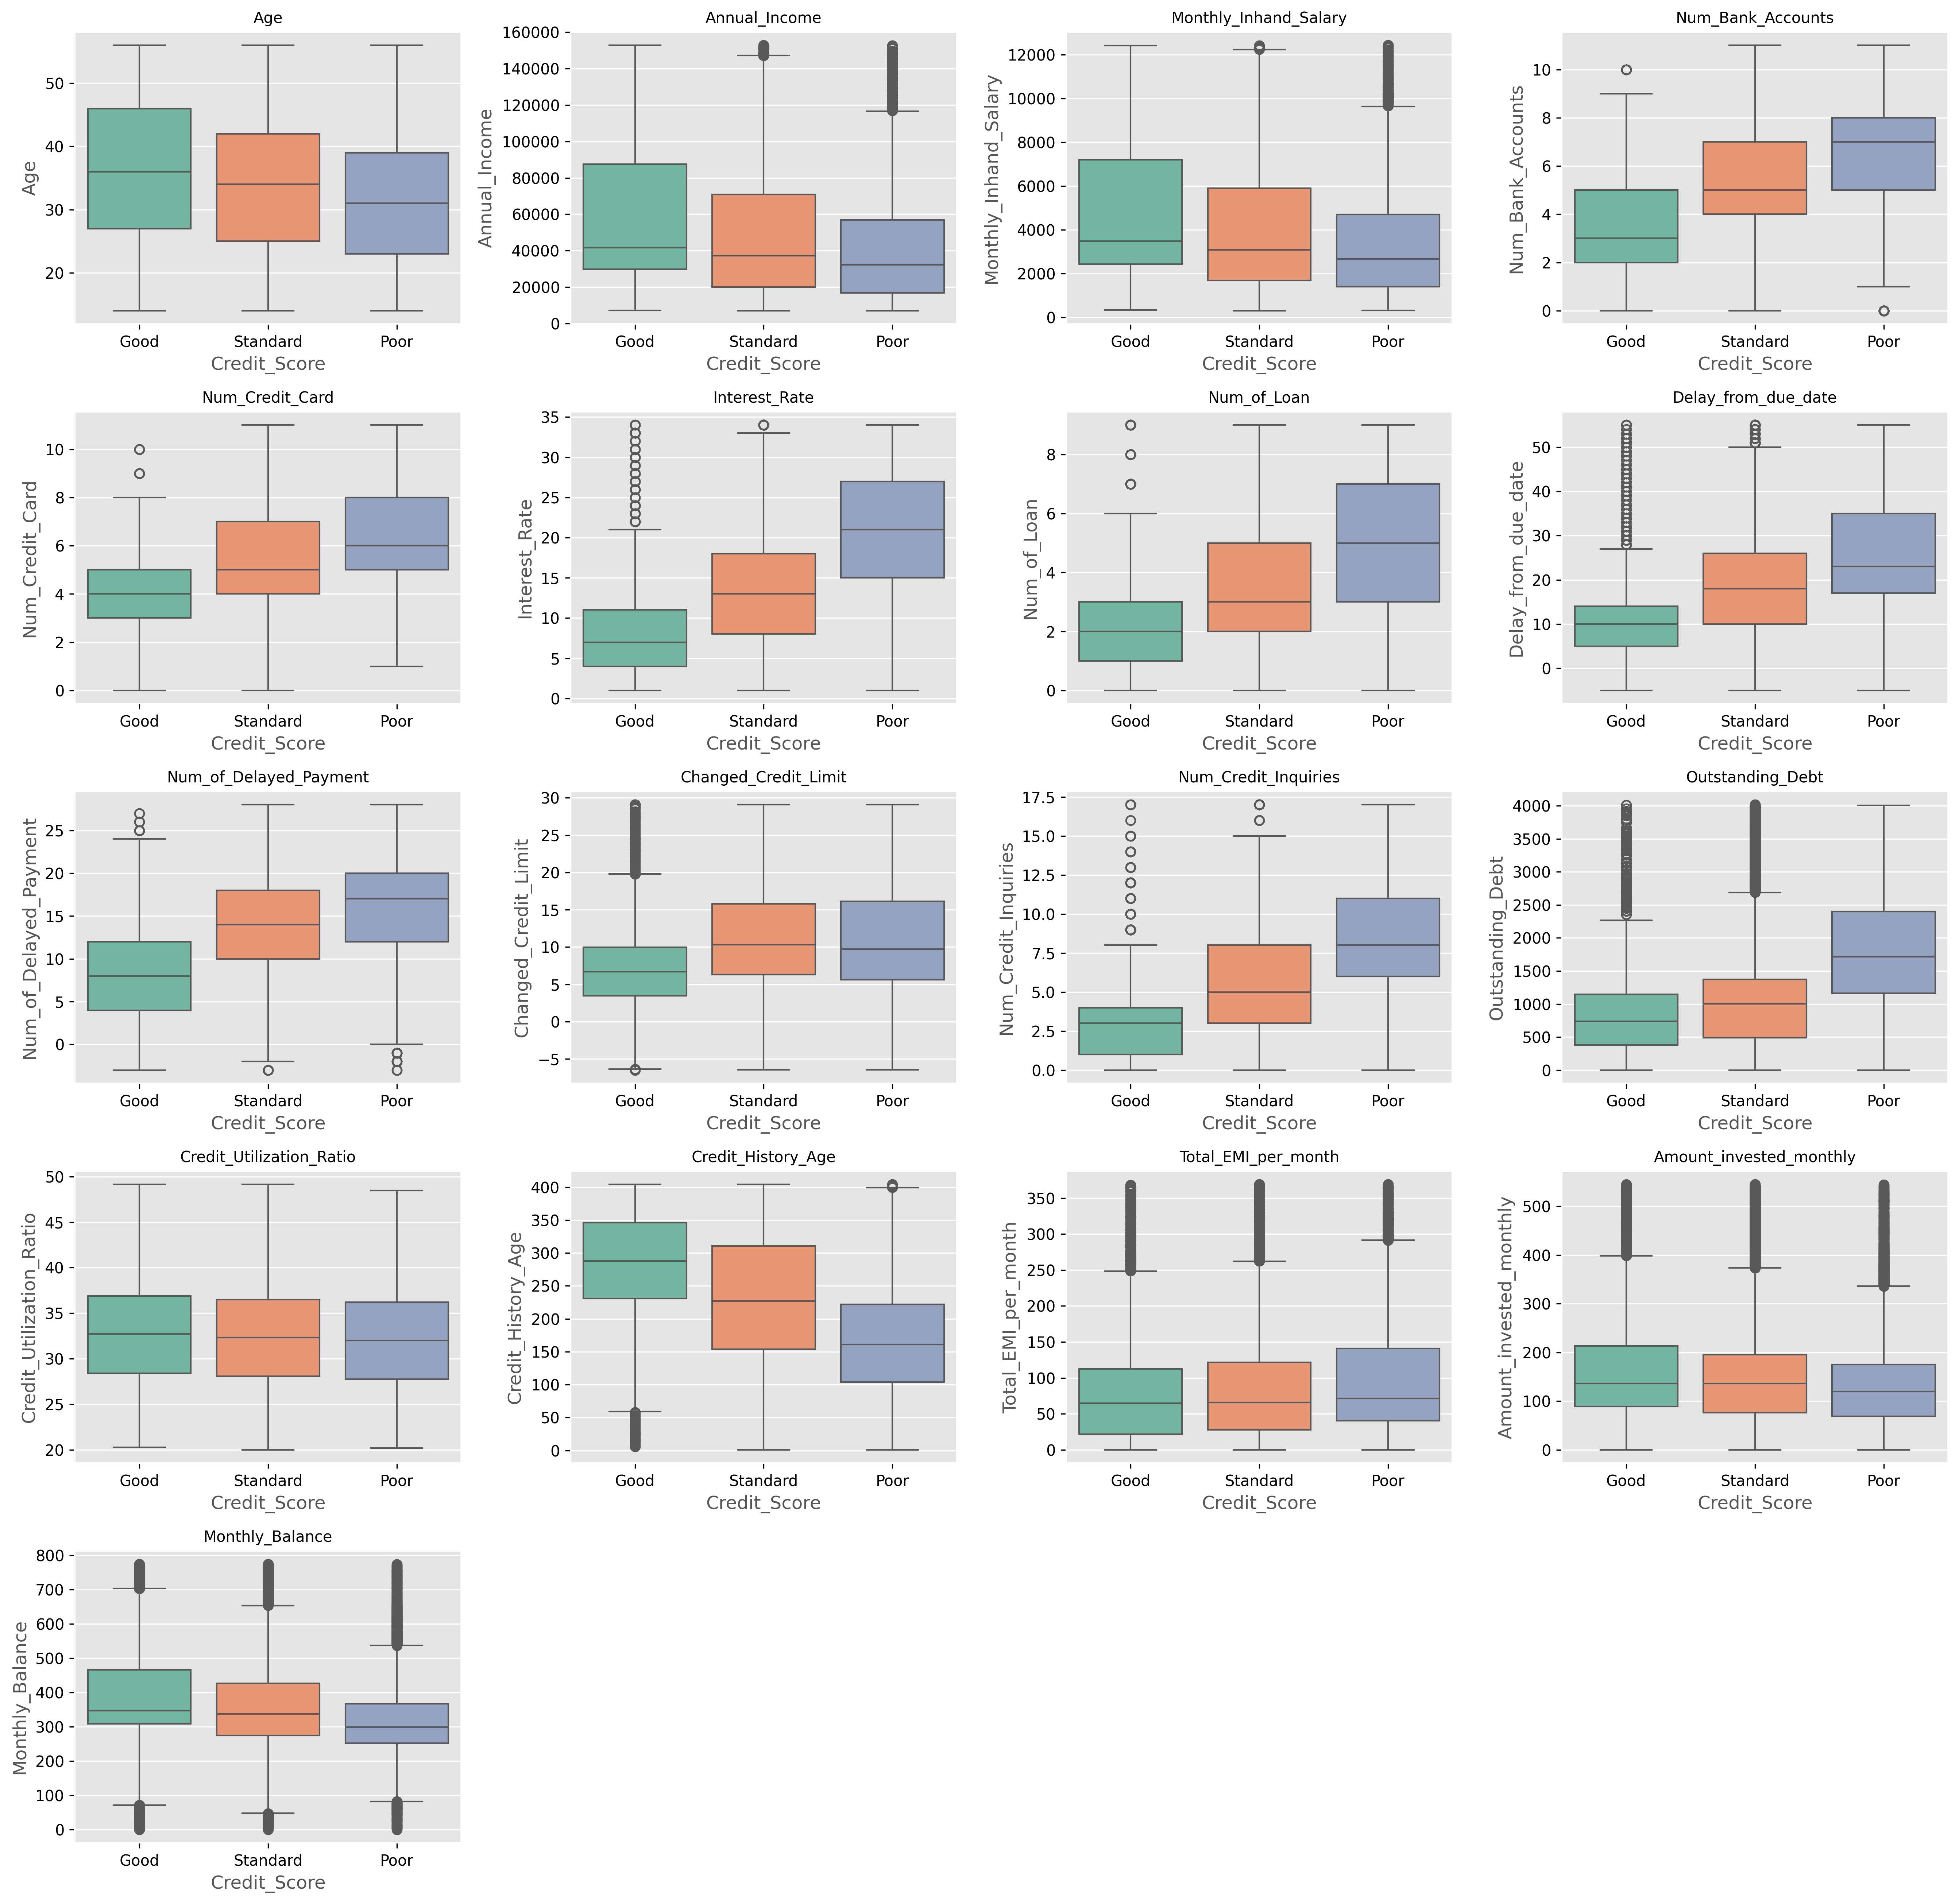

In [ ]:
plot_boxplot_num_cols(data)

<Axes: xlabel='Credit_Mix', ylabel='count'>

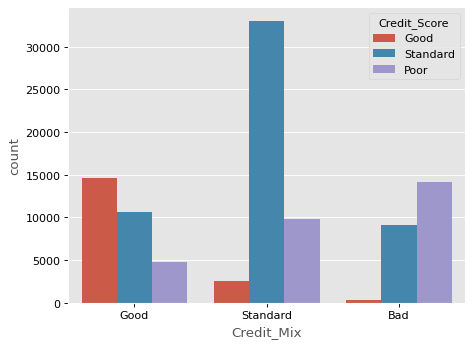

In [ ]:
sns.countplot(data=data, x="Credit_Mix", hue="Credit_Score")

In [ ]:
data.to_csv("clean_data_credit.csv", index=False)

In [ ]:
"clean_data_credit.csv" in os.listdir()

True

In [ ]:
df = pd.read_csv("clean_data_credit.csv")

In [ ]:
df_copy = data.copy()
df_copy["Monthly_Balance"] = df_copy.groupby("Customer_ID")["Monthly_Balance"].transform(lambda x: np.where((x>np.quantile(x, 0.75)) | x<np.quantile(x, 0.75), np.median(x), x))

In [ ]:
cross_tab = pd.crosstab(values=df_copy["Monthly_Balance"], index=[
                        df_copy["Credit_Score"], df_copy["Credit_Mix"]], columns="Monthly_Balance", aggfunc="mean").reset_index()

main_group = pd.pivot_table(cross_tab, "Monthly_Balance", "Credit_Score", aggfunc=np.mean)
cross_tab

col_0,Credit_Score,Credit_Mix,Monthly_Balance
0,Good,Bad,296.320348
1,Good,Good,403.335501
2,Good,Standard,387.642526
3,Poor,Bad,300.345681
4,Poor,Good,401.109600
5,Poor,Standard,343.470179
6,Standard,Bad,290.381714
7,Standard,Good,397.612596
8,Standard,Standard,387.203665


In [ ]:
b = plt.cm.Blues
a = plt.cm.Accent
# k = plt.cm.Blues(100, 0.9)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def create_pie_chart(ax, data, radius, colors, text_size, width=0.5, autopct_format="%.1f%%"):
    """
    Helper function to create a pie chart.
    """
    pie, *_, texts = ax.pie(x=data,
                            autopct=autopct_format,
                            radius=radius,
                            colors=colors,
                            textprops={"size": text_size})
    plt.setp(pie, width=width)
    return pie



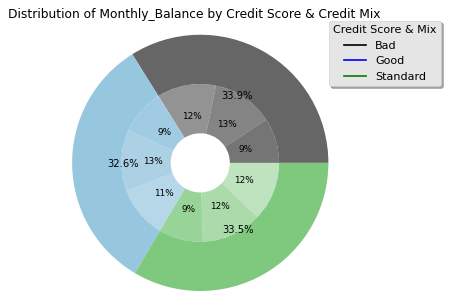

In [ ]:

# Initialize the plot
fig, ax = plt.subplots(figsize=(6, 4))
fig.suptitle("Distribution of Monthly_Balance by Credit Score & Credit Mix", fontsize=11, color="k")
fig.set_frameon(True)

# Define color functions a and b (assuming these are defined elsewhere in your code)
# a = ...
# b = ...

# Create the outer pie chart
create_pie_chart(ax, main_group["Monthly_Balance"], 1.3,
                 [a(80, 1), b(100, 1), a(0, 1)], 9, width=0.5, autopct_format="%.1f%%")

# Create the inner pie chart
create_pie_chart(ax, cross_tab["Monthly_Balance"], 0.8,
                 [a(80, 0.9), a(80, 0.8), a(80, 0.7), b(100, 0.9), b(100, 0.8), b(100, 0.7), a(0, 0.8), a(0, 0.65), a(0, 0.5)],
                 8, width=0.5, autopct_format="%.0f%%")

# Legend
legend_labels = np.unique(cross_tab["Credit_Mix"])
plt.legend(handles=[plt.Line2D([0], [0], color='k', label=legend_labels[0]),
                    plt.Line2D([0], [0], color='b', label=legend_labels[1]),
                    plt.Line2D([0], [0], color='g', label=legend_labels[-1])],
           shadow=True, frameon=True, facecolor="inherit",
           loc="best", title="Credit Score & Mix", bbox_to_anchor=(1, 1, 0.5, 0.1))

plt.show()

In [ ]:
def __plot_graph(df, col, ax, show_legend=False):
    """
    Internal function to plot a countplot for a given column.
    """
    sns.countplot(data=df, x=col, ax=ax, hue="Credit_Score")
    ax.set_xlabel(col, fontsize=9)
    ax.set_title(f"by {col}", fontsize=9)
    ax.tick_params(labelsize=7, axis="y")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=7)
    ax.grid(False)
    ax.legend_.remove() if not show_legend else ax.legend(shadow=True, loc="best", facecolor="inherit", frameon=True)

def make_countplot(df):
    """
    Creates count plots for categorical columns in the DataFrame, excluding certain columns.
    """
    cat_cols = df.select_dtypes(exclude="number").columns.drop(
        ['Credit_Score', 'is_train', 'Customer_ID', "Type_of_Loan"])

    fig, axes = plt.subplots(figsize=(12, 6), dpi=300)
    fig.suptitle("Counts of categorical columns")

    # Plot each categorical column
    for i, col in enumerate(cat_cols, 1):
        if i == 3:  # Skip the third subplot
            continue
        ax = fig.add_subplot(2, 3, i)
        __plot_graph(df, col=col, ax=ax)

    # Special handling for 'Payment_Behaviour'
    ax2 = fig.add_axes((0.74, 0.527, 0.23, 0.35))
    __plot_graph(df, col="Payment_Behaviour", ax=ax2, show_legend=True)

    plt.show()


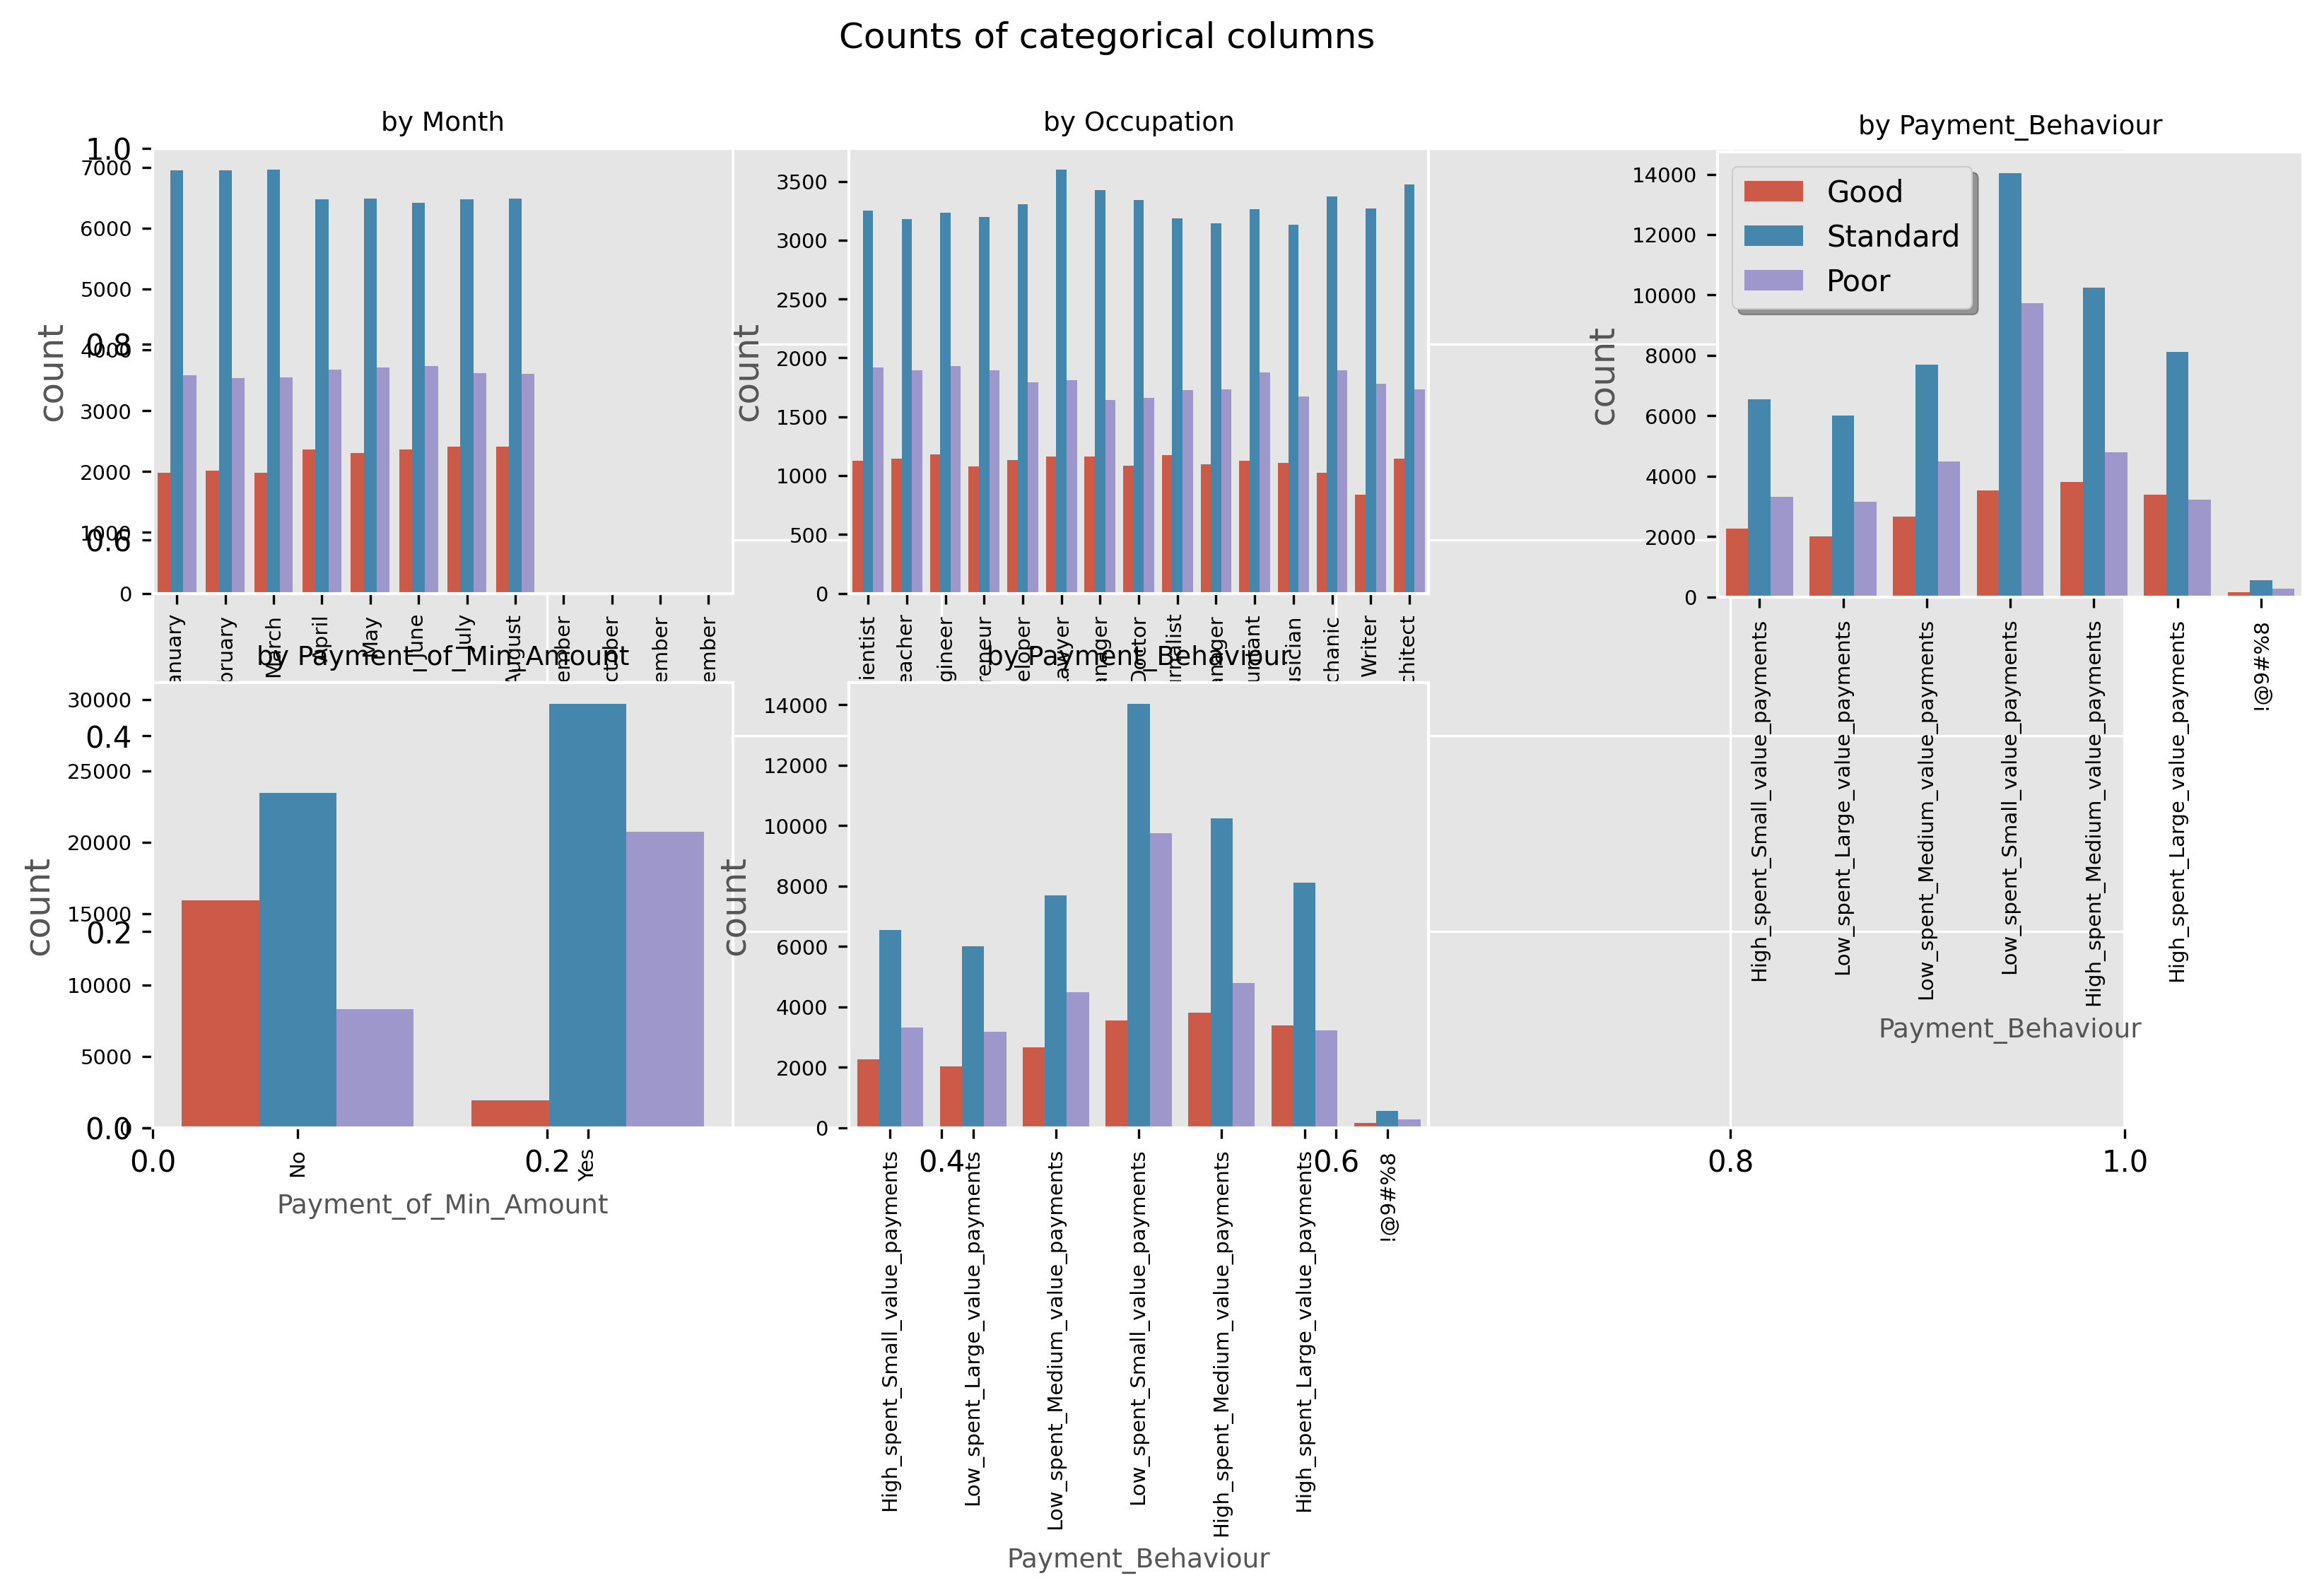

In [ ]:
make_countplot(df)

## **Correlation Heatmap and Intuition**


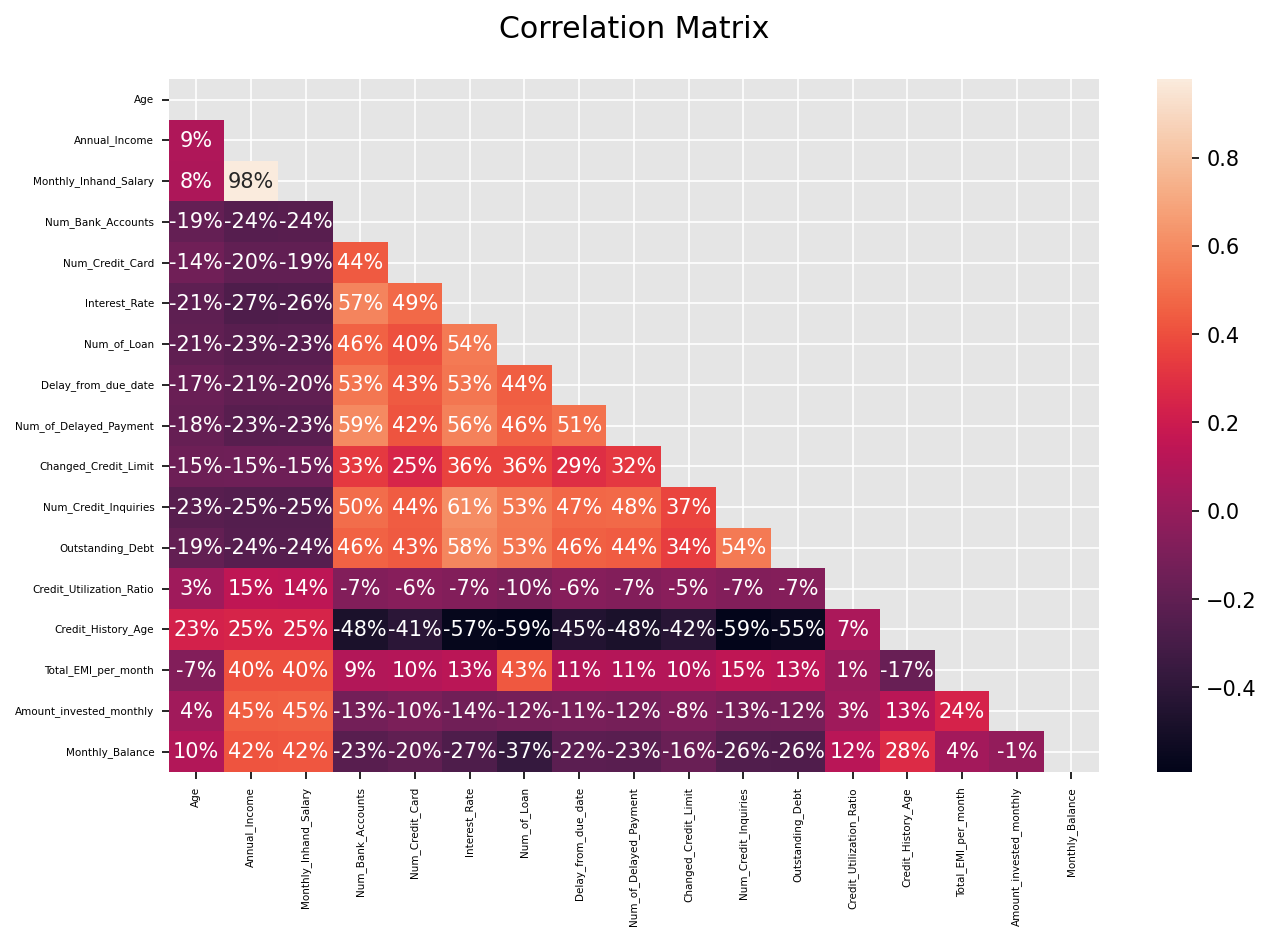

In [ ]:
# Create a heatmap to visualize the correlation matrix of the DataFrame
corr = data.drop(["is_train"], axis=1).corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
sns.heatmap(corr, annot=True, mask=mask, fmt=".0%", annot_kws={"size": 10}, ax=ax)
ax.tick_params(axis="both", labelsize=5)
ax.set_title("Correlation Matrix", pad=20)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histograms(df, numerical_columns):
    """
    Creates a grid of histograms for each numerical column in the given DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    numerical_columns (list): List of numerical column names.
    """
    num_cols = len(numerical_columns)
    num_rows = (num_cols - 1) // 3 + 1

    fig, axes = plt.subplots(num_rows, 3, figsize=(18, 4 * num_rows))

    # Plot histograms for each numerical column
    for i, col in enumerate(numerical_columns):
        ax = axes.flatten()[i]
        sns.histplot(df[col], ax=ax, bins=20, kde=True)
        ax.axvline(df[col].mean(), color='red', linestyle='dashed', linewidth=1.5, label='Mean')
        ax.axvline(df[col].median(), color='green', linestyle='dashed', linewidth=1.5, label='Median')
        ax.set_title(f'Histogram of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')

    # Create a global legend outside of the subplots
    handles, labels = axes.flatten()[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    # Remove any empty subplots
    for i in range(num_cols, num_rows * 3):
        axes.flatten()[i].set_visible(False)
    plt.tight_layout()
    plt.show()

In [ ]:

cat_columns_org = [col for col in df.columns if df[col].dtypes=='object']
num_columns_org = [col for col in df.columns if df[col].dtypes in ['int64','float64']]
print("\nColumns types:")
print(f"Columns type casted as categorical: {', '.join(cat_columns_org)}")
print(f"Columns type casted as numerical: {', '.join(num_columns_org)}")


Columns types:
Columns type casted as categorical: Customer_ID, Month, Occupation, Type_of_Loan, Credit_Mix, Payment_of_Min_Amount, Payment_Behaviour, Credit_Score
Columns type casted as numerical: Age, Annual_Income, Monthly_Inhand_Salary, Num_Bank_Accounts, Num_Credit_Card, Interest_Rate, Num_of_Loan, Delay_from_due_date, Num_of_Delayed_Payment, Changed_Credit_Limit, Num_Credit_Inquiries, Outstanding_Debt, Credit_Utilization_Ratio, Credit_History_Age, Total_EMI_per_month, Amount_invested_monthly, Monthly_Balance


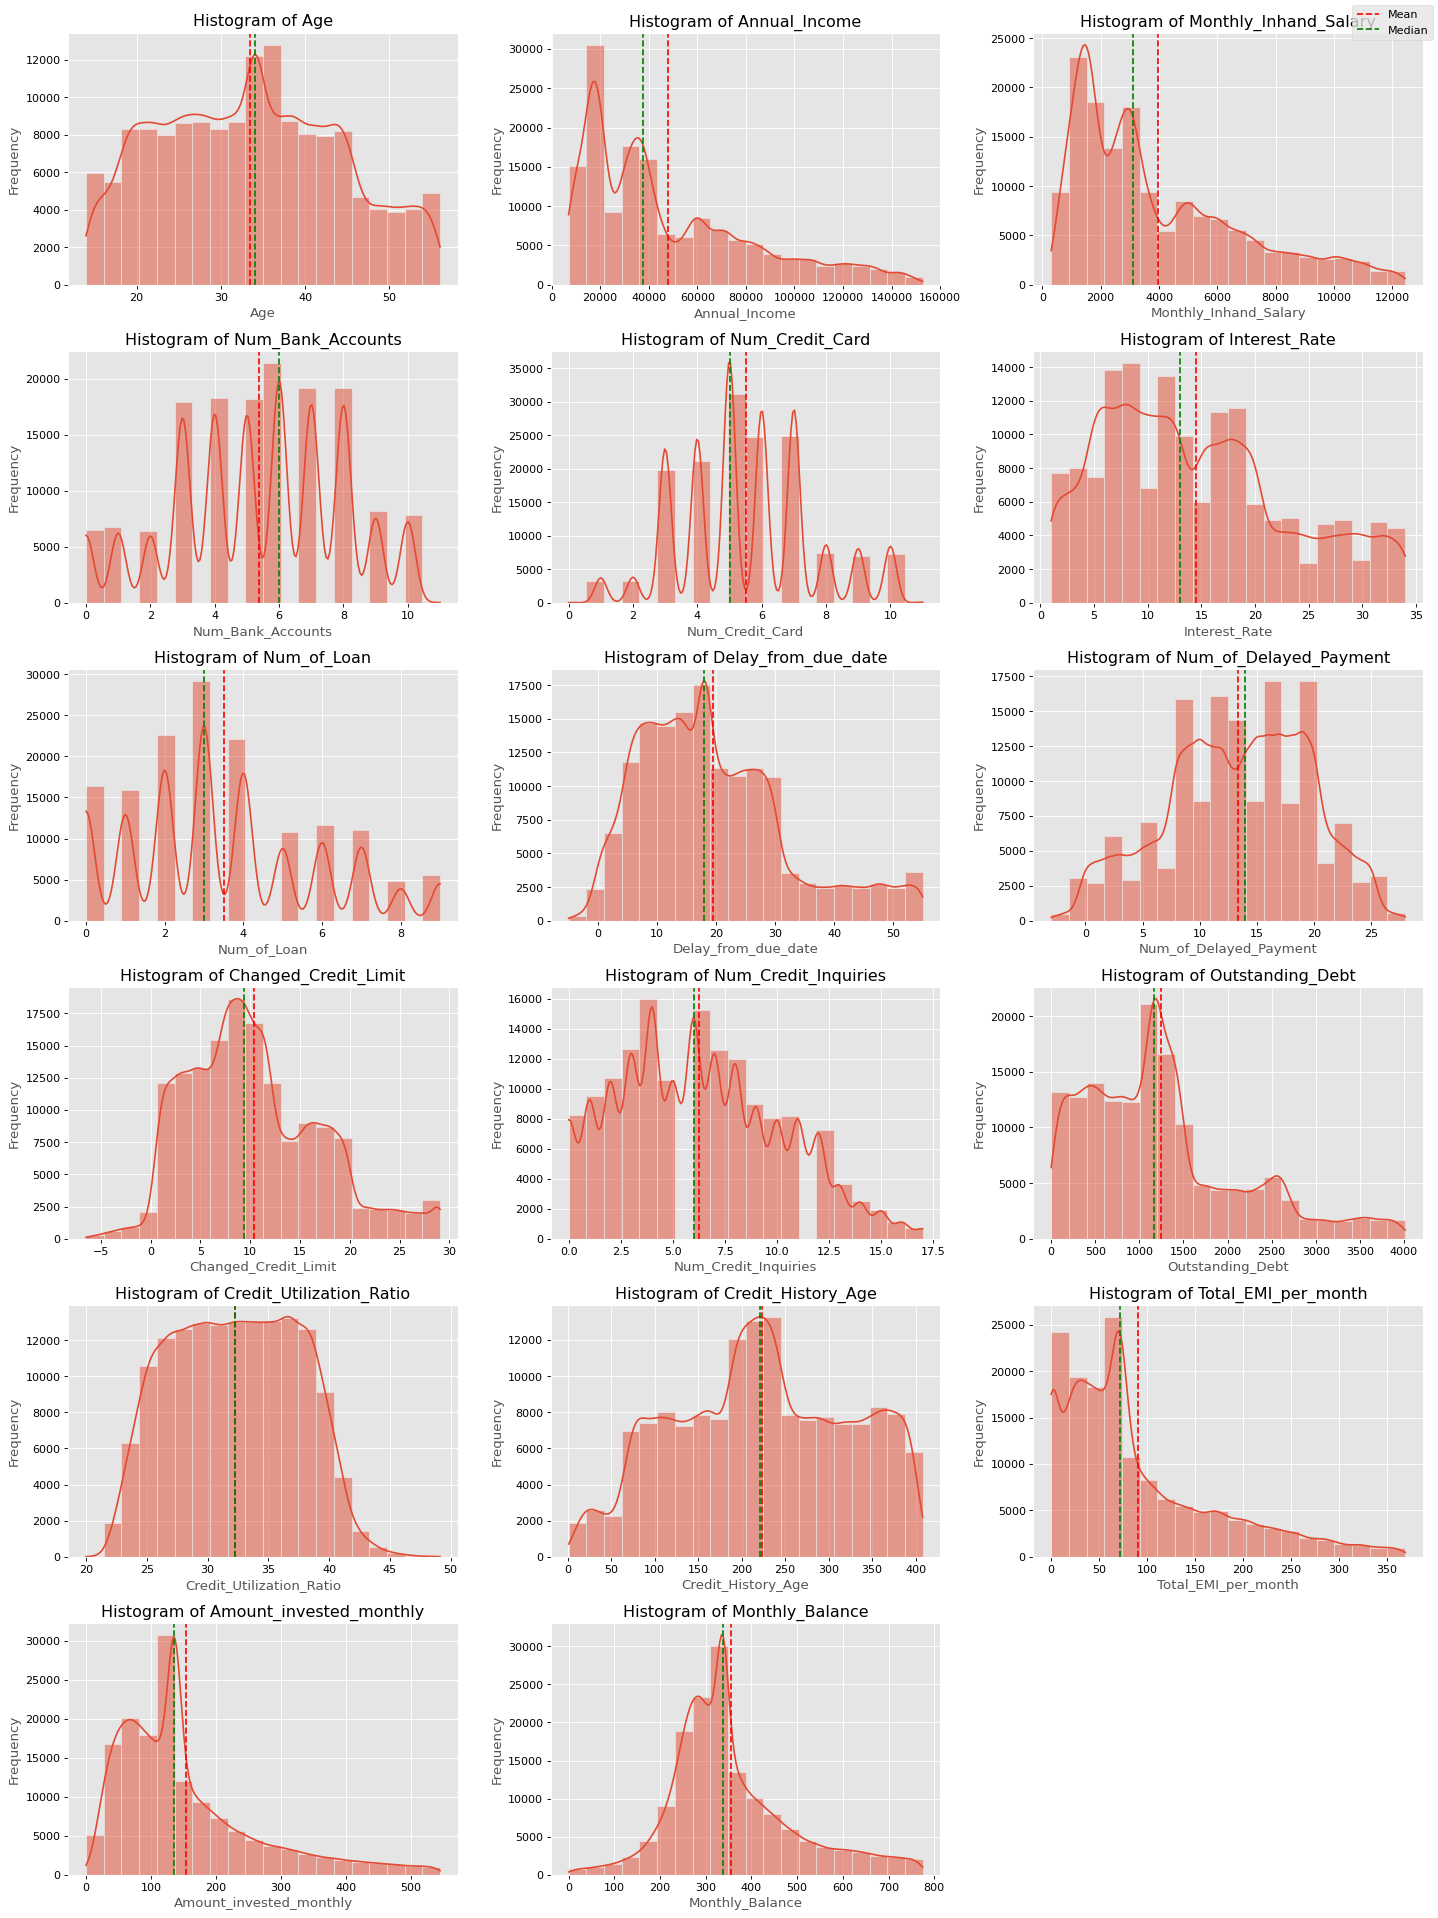

In [ ]:
plot_histograms(df, num_columns_org)

In [ ]:
# Define a mapping dictionary for month names to their numerical equivalents
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8
}

# Convert month names in the 'Month' column to their numerical values
df['Num_Month'] = df['Month'].map(month_mapping)


In [ ]:
# Calculate basic statistics and IQR for each numeric column
column_stats = df.describe(percentiles=[.25, .75])
column_stats.loc['IQR'] = column_stats.loc['75%'] - column_stats.loc['25%']
column_stats.loc['Lower limit'] = column_stats.loc['25%'] - 1.5 * column_stats.loc['IQR']
column_stats.loc['Upper limit'] = column_stats.loc['75%'] + 1.5 * column_stats.loc['IQR']

# Transpose for easier manipulation
column_stats = column_stats.T

# Detect if any outliers are present in each column
column_stats['Outlier_detected'] = column_stats.apply(
    lambda row: row['Lower limit'] > row['min'] or row['Upper limit'] < row['max'], axis=1)

# Drop unnecessary columns and format the statistics
column_stats = column_stats.drop(columns=['count', 'std', 'IQR'])
formatted_column_stats = column_stats.applymap(
    lambda x: "{:.2e}".format(x) if abs(x) >= 1e6 else "{:.2f}".format(x))

# Display the formatted DataFrame
formatted_column_stats

,mean,min,25%,50%,75%,max,Lower limit,Upper limit,Outlier_detected
Age,33.50,14.00,25.00,34.00,42.00,56.00,-0.50,67.50,0.00
Annual_Income,48054.94,7005.93,19455.49,37578.61,68665.76,152796.76,-54359.91,142481.16,1.00
Monthly_Inhand_Salary,3975.27,303.65,1625.56,3091.00,5699.96,12435.17,-4486.05,11811.57,1.00
Num_Bank_Accounts,5.38,0.00,3.00,6.00,7.00,11.00,-3.00,13.00,0.00
Num_Credit_Card,5.52,0.00,4.00,5.00,7.00,11.00,-0.50,11.50,0.00
Interest_Rate,14.50,1.00,8.00,13.00,20.00,34.00,-10.00,38.00,0.00
Num_of_Loan,3.51,0.00,2.00,3.00,5.00,9.00,-2.50,9.50,0.00
Delay_from_due_date,19.41,-5.00,10.00,18.00,26.00,55.00,-14.00,50.00,1.00
Num_of_Delayed_Payment,13.32,-3.00,9.00,14.00,18.00,28.00,-4.50,31.50,0.00
Changed_Credit_Limit,10.38,-6.49,5.34,9.40,14.83,29.07,-8.89,29.06,1.00


In [ ]:
df = df.sort_values(['Customer_ID',"Num_Month"])
df.reset_index(inplace=True)
df = df.drop(columns="index")
df = df.fillna(df.shift(1))

In [ ]:
num_rows_old = df.shape[0]
print(f"Total shape before: {df.shape[0]}")
df.dropna(inplace=True)

num_rows_new = df.shape[0]
print(f"Total shape after : {df.shape[0]}, percentage drop : {((num_rows_old-num_rows_new)/num_rows_old)*100:.2f} %")

Total shape before: 150000
Total shape after : 100026, percentage drop : 33.32 %


In [ ]:
def convert_years_months_to_months(df, column_name):
    """
    Converts a column containing strings with years and months into a single integer column of months.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column to convert.

    Returns:
    pd.DataFrame: The DataFrame with the converted column.
    """
    # Ensure the column is of string type
    df[column_name] = df[column_name].astype(str)

    # Extract years and months
    df['Years'] = df[column_name].str.extract(r'(\d+) Years').fillna(0).astype(int)
    df['Months'] = df[column_name].str.extract(r'(\d+) Months').fillna(0).astype(int)

    # Calculate total months and update the DataFrame
    df['Credit_History_Age'] = df['Years'] * 12 + df['Months']

    # Drop the temporary columns
    df.drop(['Years', 'Months'], axis=1, inplace=True)

    return df

# Apply the function to the DataFrame
df = convert_years_months_to_months(df, 'Credit_History_Age')

In [ ]:
##Type casting the columns
def type_cast_fn(df,column_list,data_type):
    for col in column_list:
        df[col] = df[col].astype(str).str.replace('_', '')
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df
convert_to_int = ["Age","Num_of_Loan"]
df = type_cast_fn(df,convert_to_int,'int64')

convert_to_float = ["Num_of_Delayed_Payment",'Annual_Income','Outstanding_Debt','Changed_Credit_Limit','Num_of_Loan',
                    'Credit_Utilization_Ratio','Amount_invested_monthly','Monthly_Balance']

df = type_cast_fn(df,convert_to_float,'float64')

In [ ]:
print(df.dtypes)

cat_columns_org = [col for col in df.columns if df[col].dtypes=='object']
num_columns_org = [col for col in df.columns if df[col].dtypes in ['int64','float64']]
print("\nColumns types:")
print(f"Columns type casted as categorical: {', '.join(cat_columns_org)}")
print(f"Columns type casted as numerical: {', '.join(num_columns_org)}")

Customer_ID                  object
Month                        object
Age                         float64
Occupation                   object
Annual_Income               float64
Monthly_Inhand_Salary       float64
Num_Bank_Accounts           float64
Num_Credit_Card             float64
Interest_Rate               float64
Num_of_Loan                 float64
Type_of_Loan                 object
Delay_from_due_date         float64
Num_of_Delayed_Payment      float64
Changed_Credit_Limit        float64
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt            float64
Credit_Utilization_Ratio    float64
Credit_History_Age            int64
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly     float64
Payment_Behaviour            object
Monthly_Balance             float64
Credit_Score                 object
is_train                       bool
Num_Month                   float64
dtype: object

Columns types

In [ ]:
columns_to_convert = ['Age', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate',
                      'Num_of_Loan', 'Delay_from_due_date', 'Credit_History_Age', 'Num_Month']

# Convert each column to int64
for column in columns_to_convert:
    df[column] = df[column].fillna(0).astype(int)

# Check the data types again
print(df.dtypes)

Customer_ID                  object
Month                        object
Age                           int64
Occupation                   object
Annual_Income               float64
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                   int64
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment      float64
Changed_Credit_Limit        float64
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt            float64
Credit_Utilization_Ratio    float64
Credit_History_Age            int64
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly     float64
Payment_Behaviour            object
Monthly_Balance             float64
Credit_Score                 object
is_train                       bool
Num_Month                     int64
dtype: object


In [ ]:
def convert_years_months_to_months(df, column_name):
    """
    Converts a column containing strings with years and months into a single integer column of months.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column to convert.

    Returns:
    pd.DataFrame: The DataFrame with the converted column.
    """
    # Ensure the column is of string type
    df[column_name] = df[column_name].astype(str)

    # Extract years and months
    df['Years'] = df[column_name].str.extract(r'(\d+) Years').fillna(0).astype(int)
    df['Months'] = df[column_name].str.extract(r'(\d+) Months').fillna(0).astype(int)

    # Calculate total months and update the DataFrame
    df['Credit_History_Age'] = df['Years'] * 12 + df['Months']

    # Drop the temporary columns
    df.drop(['Years', 'Months'], axis=1, inplace=True)

    return df

# Apply the function to the DataFrame
df = convert_years_months_to_months(df, 'Credit_History_Age')


In [ ]:
print("Distribution of target columns: \n")
print(df.Credit_Score.value_counts())

Distribution of target columns: 

Standard    52562
Poor        30932
Good        16532
Name: Credit_Score, dtype: int64


In [ ]:
df.rename(columns={'Credit_Score': 'Loan_Approval_Status'}, inplace=True)

In [ ]:
# Count the number of entries with 'Good' credit score
total_limit = df['Loan_Approval_Status'][df.Loan_Approval_Status == "Good"].count()

# Randomly sample 'Standard' and 'Poor' credit score entries to match half of 'Good' count each
standard_df = df[df['Loan_Approval_Status'] == 'Standard'].sample(n=total_limit // 2, random_state=42)
poor_df = df[df['Loan_Approval_Status'] == 'Poor'].sample(n=total_limit // 2, random_state=42)

# Get all entries with 'Good' credit score
good_df = df[df['Loan_Approval_Status'] == 'Good']

# Combine 'Standard' and 'Poor' into a single DataFrame and label their credit score as 'Not good'
combined_not_good_df = pd.concat([standard_df, poor_df])
combined_not_good_df['Loan_Approval_Status'] = "Not good"

# Combine the 'Not good' and 'Good' DataFrames
balanced_df = pd.concat([combined_not_good_df, good_df])

# Reset the index of the combined DataFrame
balanced_df = balanced_df.reset_index(drop=True)

# Update the original DataFrame
df = balanced_df


In [ ]:
print("Distribution of target columns: \n")
print(balanced_df.Loan_Approval_Status.value_counts())

Distribution of target columns: 

Not good    16532
Good        16532
Name: Loan_Approval_Status, dtype: int64


In [ ]:

def data_split(df, target_column, test_ratio=0.1):
    """
    Splits the DataFrame into training, testing, and validation sets.

    Parameters:
    df (pd.DataFrame): The DataFrame to split.
    target_column (str): The name of the target column for stratification.
    test_ratio (float, optional): The proportion of the dataset to include in the test split.

    Returns:
    tuple: A tuple containing the training, testing, and validation DataFrames.
    """
    valid_ratio = test_ratio
    train_ratio = 1 - test_ratio - valid_ratio

    # Splitting the DataFrame into training and temporary DataFrame (test + valid)
    train_df, temp_df = train_test_split(df, test_size=(1 - train_ratio), random_state=42, stratify=df[target_column])

    # Splitting the temporary DataFrame into test and validation DataFrames
    test_df, valid_df = train_test_split(temp_df, test_size=test_ratio/(test_ratio + valid_ratio), random_state=42)

    return train_df, test_df, valid_df

In [ ]:
# Encode 'Payment_of_Min_Amount' column with binary values
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].map({'Yes': 1, 'No': 0})

# Drop irrelevant or redundant columns
df = df.drop(columns=['Customer_ID', 'Month', 'Type_of_Loan'])

# Encode 'Loan_Approval_Status' column with binary values
df['Loan_Approval_Status'] = df['Loan_Approval_Status'].map({'Not good': 0, 'Good': 1})

# Split the data into train, test, and validation sets
train_df, test_df, valid_df = data_split(df, test_ratio=0.15, target_column='Loan_Approval_Status')


In [ ]:
# Target encoding for 'Occupation'
#target_enc = TargetEncoder()
#train_df['Occupation'] = target_enc.fit_transform(train_df['Occupation'], y=train_df['Loan_Approval_Status'])
#valid_df['Occupation'] = target_enc.transform(valid_df['Occupation'])
#test_df['Occupation'] = target_enc.transform(test_df['Occupation'])

# Ordinal encoding for 'Payment_Behaviour'
ordinal_mapping = {
    'High_spent_Large_value_payments': 6,
    'High_spent_Medium_value_payments': 5,
    'High_spent_Small_value_payments': 4,
    'Low_spent_Large_value_payments': 3,
    'Low_spent_Medium_value_payments': 2,
    'Low_spent_Small_value_payments': 1
}
count_enc_pay = OrdinalEncoder()
train_df['Payment_Behaviour'] = count_enc_pay.fit_transform(train_df['Payment_Behaviour'], mapping=ordinal_mapping)
valid_df['Payment_Behaviour'] = count_enc_pay.transform(valid_df['Payment_Behaviour'])
test_df['Payment_Behaviour'] = count_enc_pay.transform(test_df['Payment_Behaviour'])

# Ordinal encoding for 'Credit_Mix'
credit_mix_mapping = {'Bad': 1, 'Standard': 2, 'Good': 3}
ordinal_enc_mix = OrdinalEncoder()
train_df['Credit_Mix'] = ordinal_enc_mix.fit_transform(train_df['Credit_Mix'], mapping=credit_mix_mapping)
valid_df['Credit_Mix'] = ordinal_enc_mix.transform(valid_df['Credit_Mix'])
test_df['Credit_Mix'] = ordinal_enc_mix.transform(test_df['Credit_Mix'])


In [ ]:
def metric_calculator(y_test,y_pred,y_prob=None):
    print(f"Accuracy classification score: {accuracy_score(y_test, y_pred)}")
    print(f"Precision score: {precision_score(y_test, y_pred)}")
    print(f"Recall score: {precision_score(y_test, y_pred)}")
    print(f"F1 score: {f1_score(y_test, y_pred)}")

In [ ]:

def plot_roc_curve(ax, fpr, tpr, roc_auc, model_name):
    ax.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')

def plot_precision_recall_curve(ax, recall, precision, pr_auc, model_name):
    ax.plot(recall, precision, lw=2, label=f'{model_name} (AUC = {pr_auc:.2f})')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend(loc='upper right')

def plot_metrics_multi_models(y_test, model_probabilities):
    """
    Plots ROC and Precision-Recall curves for multiple models.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for model_name, y_prob_test in model_probabilities.items():
        # Calculate metrics for ROC and Precision-Recall curves
        fpr, tpr, _ = roc_curve(y_test, y_prob_test[:, 1])
        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(y_test, y_prob_test[:, 1])
        pr_auc = average_precision_score(y_test, y_prob_test[:, 1])

        # Plot curves
        plot_roc_curve(axes[0], fpr, tpr, roc_auc, model_name)
        plot_precision_recall_curve(axes[1], recall, precision, pr_auc, model_name)

    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[0].grid()

    axes[1].set_title('Precision-Recall Curve')
    axes[1].grid()

    plt.tight_layout()
    plt.show()




## **Web Application**


In [ ]:
import joblib

# Assuming 'rf_model' is your optimized Random Forest pipeline
joblib.dump(model_rf, 'random_forest_model_1.joblib')

## **Model 1:Decision Tree**




In [ ]:

target_column = 'Loan_Approval_Status'

# Prepare the feature and target data
X_train = train_df.drop(columns=[target_column])
y_train = train_df[target_column]
X_valid = valid_df.drop(columns=[target_column])
y_valid = valid_df[target_column]

# Define the model
model_1 = DecisionTreeClassifier(criterion='gini', max_depth=10, max_features='sqrt', random_state=42)

# Train the model
model_1.fit(X_train, y_train)

# Predictions on train and validation sets
y_pred_train_1 = model_1.predict(X_train)
y_prob_train_1 = model_1.predict_proba(X_train)
y_pred_valid_1 = model_1.predict(X_valid)
y_prob_valid_1 = model_1.predict_proba(X_valid)

# Evaluate and print results
print("Train results:")
print(metric_calculator(y_train, y_pred_train_1, y_prob=y_prob_train_1))
print("---" * 15)
print("Validation results:")
print(metric_calculator(y_valid, y_pred_valid_1, y_prob=y_prob_valid_1))

Train results:
Accuracy classification score: 0.8512357414448669
Precision score: 0.8358813321213123
Recall score: 0.8358813321213123
F1 score: 0.8545600473112829
None
---------------------------------------------
Validation results:
Accuracy classification score: 0.8270161290322581
Precision score: 0.8194875776397516
Recall score: 0.8194875776397516
F1 score: 0.8311023622047244
None


In [ ]:

# Define the hyperparameters you want to tune
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create GridSearchCV object with additional parameters for efficiency and logging
grid_search = GridSearchCV(
    estimator=model_1,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit the model to the training data
grid_search.fit(train_df.drop(columns=[target_column]), train_df[target_column])

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 3 folds for each of 90 candidates, totalling 270 fits
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}


## **Decision Tree after Tuning**


Test results:
Accuracy classification score: 0.8455645161290323
Precision score: 0.8262548262548263
Recall score: 0.8262548262548263
F1 score: 0.8481965913594927


<Axes: >

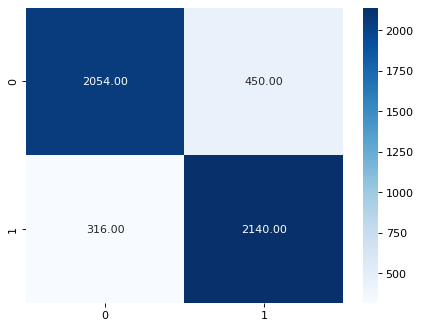

In [ ]:

target_column = 'Loan_Approval_Status'

# Prepare the data
X_train = train_df.drop(columns=[target_column])
y_train = train_df[target_column]
X_test = test_df.drop(columns=[target_column])
y_test = test_df[target_column]

# Define and train the model
decision_tree_model = DecisionTreeClassifier(**best_params)
decision_tree_model.fit(X_train, y_train)

# Make predictions
y_pred = decision_tree_model.predict(X_test)
y_prob = decision_tree_model.predict_proba(X_test)

# Evaluate the model
print("Test results:")
metric_calculator(y_test, y_pred, y_prob=y_prob)

# Plot confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, fmt='.2f', cmap='Blues')

## **Model 2:Random-Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

target_column = 'Loan_Approval_Status'
# Prepare the feature and target data for random forest
X_train_rf = train_df.drop(columns=[target_column])
y_train_rf = train_df[target_column]
X_valid_rf = valid_df.drop(columns=[target_column])
y_valid_rf = valid_df[target_column]

# Define the random forest model
model_rf = RandomForestClassifier(n_estimators=100, max_depth=10, max_features='sqrt', random_state=42)

# Train the random forest model
model_rf.fit(X_train_rf, y_train_rf)

# Predictions on train and validation sets
y_pred_train_rf = model_rf.predict(X_train_rf)
y_prob_train_rf = model_rf.predict_proba(X_train_rf)
y_pred_valid_rf = model_rf.predict(X_valid_rf)
y_prob_valid_rf = model_rf.predict_proba(X_valid_rf)

# Evaluate and print results for random forest
print("Random Forest Train results:")
print("Accuracy:", accuracy_score(y_train_rf, y_pred_train_rf))
print("Confusion Matrix:\n", confusion_matrix(y_train_rf, y_pred_train_rf))
print("Classification Report:\n", classification_report(y_train_rf, y_pred_train_rf))
print("---" * 15)
print("Random Forest Test results:")
print("Accuracy:", accuracy_score(y_valid_rf, y_pred_valid_rf))
print("Confusion Matrix:\n", confusion_matrix(y_valid_rf, y_pred_valid_rf))
print("Classification Report:\n", classification_report(y_valid_rf, y_pred_valid_rf))


Random Forest Train results:
Accuracy: 0.8788454891116488
Confusion Matrix:
 [[ 9948  1624]
 [ 1180 10392]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.88     11572
           1       0.86      0.90      0.88     11572

    accuracy                           0.88     23144
   macro avg       0.88      0.88      0.88     23144
weighted avg       0.88      0.88      0.88     23144

---------------------------------------------
Random Forest Test results:
Accuracy: 0.8504032258064517
Confusion Matrix:
 [[2074  382]
 [ 360 2144]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85      2456
           1       0.85      0.86      0.85      2504

    accuracy                           0.85      4960
   macro avg       0.85      0.85      0.85      4960
weighted avg       0.85      0.85      0.85      4960



In [ ]:

# Adjusted range of hyperparameters
param_distributions = {
    'n_estimators': [50, 100, 150],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, None],
    'max_features': ['auto', 'sqrt']
}

cls_classifier = RandomForestClassifier(random_state=42)

# Using RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(cls_classifier, param_distributions=param_distributions,
                                   n_iter=10,  # Number of parameter settings that are sampled
                                   scoring='roc_auc', cv=3, n_jobs=-1, random_state=42)

random_search.fit(train_df.drop(columns=[target_column]), train_df[target_column])

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)



Best Hyperparameters: {'n_estimators': 100, 'max_features': 'auto', 'max_depth': None, 'criterion': 'entropy'}


## **Random Forest after Tuning**


Accuracy classification score: 0.8923387096774194
Precision score: 0.8681992337164751
Recall score: 0.8681992337164751
F1 score: 0.8945913936044215


<Axes: >

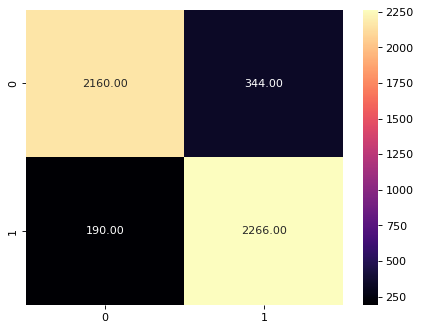

In [ ]:

target_column = 'Loan_Approval_Status'

# Define and train the RandomForest model with the best parameters
model_2 = RandomForestClassifier(**best_params)
train_features = train_df.drop(columns=[target_column])
train_target = train_df[target_column]
model_2.fit(train_features, train_target)

# Prepare test data and make predictions
test_features = test_df.drop(columns=[target_column])
y_test_2 = test_df[target_column]
y_pred_2 = model_2.predict(test_features)
y_prob_2 = model_2.predict_proba(test_features)

# Evaluate the model using custom metric calculator
metric_calculator(y_test_2, y_pred_2, y_prob=y_prob_2)

# Generate and display the confusion matrix
cf_matrix = confusion_matrix(y_test_2, y_pred_2)
sns.heatmap(cf_matrix, annot=True, fmt='.2f', cmap='magma')

## **Model 3:Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [ ]:
model_3 = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))

# Train the model on the training data
model_3.fit(X_train, y_train)

# Predictions on train and validation sets
y_pred_train_3 = model_3.predict(X_train)
y_prob_train_3 = model_3.predict_proba(X_train)[:, 1] # get probabilities for the positive class
y_pred_valid_3 = model_3.predict(X_valid)
y_prob_valid_3 = model_3.predict_proba(X_valid)[:, 1] # get probabilities for the positive class

# Evaluate and print results for the logistic regression model
print("Train results for Logistic Regression:")
print(metric_calculator(y_train, y_pred_train_3, y_prob=y_prob_train_3))
print("---" * 15)
print("Validation results for Logistic Regression:")
print(metric_calculator(y_valid, y_pred_valid_3, y_prob=y_prob_valid_3))


Train results for Logistic Regression:
Accuracy classification score: 0.8225890079502247
Precision score: 0.8148085680553213
Recall score: 0.8148085680553213
F1 score: 0.8247545881348698
None
---------------------------------------------
Validation results for Logistic Regression:
Accuracy classification score: 0.8235887096774194
Precision score: 0.8220640569395018
Recall score: 0.8220640569395018
F1 score: 0.8261474269819193
None


## **Logistic Regession after Tuning**

Test results:
Accuracy classification score: 0.7967741935483871
Precision score: 0.7646198830409356
Recall score: 0.7646198830409356
F1 score: 0.8058551617873652
None


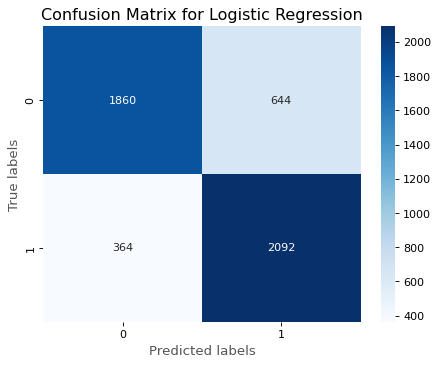

In [ ]:
best_params_lr = {'C': 1, 'max_iter': 100, 'solver': 'liblinear'}

# Prepare the data
X_train_3 = train_df.drop(columns=[target_column])
y_train_3 = train_df[target_column]
X_test_3 = test_df.drop(columns=[target_column])
y_test_3 = test_df[target_column]

# Define and train the Logistic Regression model with best parameters
logistic_model = LogisticRegression(**best_params_lr, random_state=42)
logistic_model.fit(X_train_3, y_train_3)

# Make predictions
y_pred_3 = logistic_model.predict(X_test_3)
y_prob_3 = logistic_model.predict_proba(X_test_3)

# Evaluate the model
print("Test results:")
print(metric_calculator(y_test_3, y_pred_3, y_prob=y_prob_3))  # Assuming metric_calculator is a defined function

# Plot confusion matrix
cf_matrix = confusion_matrix(y_test_3, y_pred_3)
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')  # 'g' for integer formatting
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

## **Model 4: GBM**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

target_column = 'Loan_Approval_Status'

# Function to train and evaluate the model
def train_and_evaluate(model, train_df, valid_df, target_column):
    # Training the model
    model.fit(train_df.drop(columns=[target_column]), train_df[target_column])

    # Predictions and probabilities for train and validation sets
    y_pred_train = model.predict(train_df.drop(columns=[target_column]))
    y_prob_train = model.predict_proba(train_df.drop(columns=[target_column]))[:, 1]

    y_pred_valid = model.predict(valid_df.drop(columns=[target_column]))
    y_prob_valid = model.predict_proba(valid_df.drop(columns=[target_column]))[:, 1]

    # Calculating metrics
    train_accuracy = accuracy_score(train_df[target_column], y_pred_train)
    train_roc_auc = roc_auc_score(train_df[target_column], y_prob_train)

    valid_accuracy = accuracy_score(valid_df[target_column], y_pred_valid)
    valid_roc_auc = roc_auc_score(valid_df[target_column], y_prob_valid)

    train_results = {'Accuracy': train_accuracy, 'ROC-AUC': train_roc_auc}
    valid_results = {'Accuracy': valid_accuracy, 'ROC-AUC': valid_roc_auc}

    return train_results, valid_results

# Define the Gradient Boosting Machine (GBM) model (model 5)
model_gbm = GradientBoostingClassifier(n_estimators=100, max_depth=10, random_state=42)  # GBM model

# Train the GBM model and print the results
train_results, valid_results = train_and_evaluate(model_gbm, train_df, valid_df, target_column)

print("Train results:")
print(train_results)
print("---" * 15)
print("Test results:")
print(valid_results)

Train results:
{'Accuracy': 0.9927843069478051, 'ROC-AUC': 0.9998372055316903}
---------------------------------------------
Test results:
{'Accuracy': 0.9008064516129032, 'ROC-AUC': 0.952512787357817}


# **Solving Overfitting for GBM- Using Lasso**

In [ ]:
target_column = 'Loan_Approval_Status'

# Function to train and evaluate the model
def train_and_evaluate(model, train_df, valid_df, target_column):
    # Training the model
    model.fit(train_df.drop(columns=[target_column]), train_df[target_column])

    # Predictions for train and validation sets
    y_pred_train = model.predict(train_df.drop(columns=[target_column]))
    y_pred_valid = model.predict(valid_df.drop(columns=[target_column]))

    # Probabilities for validation set
    if hasattr(model, "predict_proba"):
        y_prob_valid = model.predict_proba(valid_df.drop(columns=[target_column]))[:, 1]
    else:
        y_prob_valid = None

    # Calculating metrics
    train_accuracy = accuracy_score(train_df[target_column], y_pred_train)

    valid_accuracy = accuracy_score(valid_df[target_column], y_pred_valid)
    valid_roc_auc = roc_auc_score(valid_df[target_column], y_prob_valid) if y_prob_valid is not None else None

    train_results = {'Accuracy': train_accuracy}
    valid_results = {'Accuracy': valid_accuracy, 'ROC-AUC': valid_roc_auc}

    return train_results, valid_results

# Define the Logistic Regression model with Lasso regularization
lasso_logistic_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

# Train the Lasso logistic regression model and print the results
train_results, valid_results = train_and_evaluate(lasso_logistic_model, train_df, valid_df, target_column)

print("Train results:")
print(train_results)
print("---" * 15)
print("Test results:")
print(valid_results)

Train results:
{'Accuracy': 0.8227618389215348}
---------------------------------------------
Test results:
{'Accuracy': 0.8235887096774194, 'ROC-AUC': 0.8810967598422328}


## **Lasso Plot**

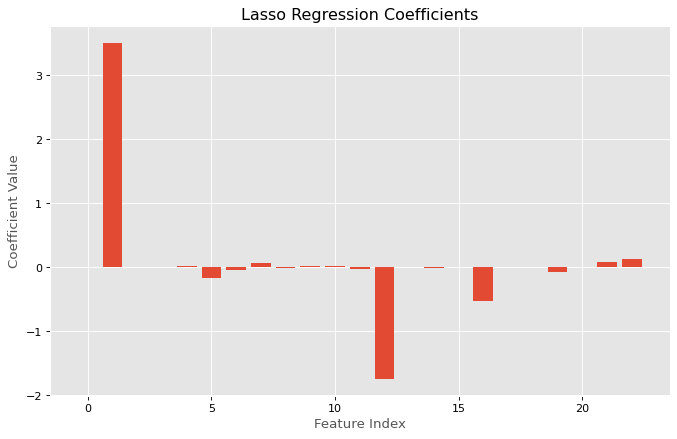

In [ ]:
import matplotlib.pyplot as plt

# Train the Lasso logistic regression model and get the coefficients
lasso_logistic_model.fit(train_df.drop(columns=[target_column]), train_df[target_column])
coefficients = lasso_logistic_model.coef_[0]

# Plotting the Lasso regression coefficients
plt.figure(figsize=(10, 6))
plt.bar(range(len(coefficients)), coefficients)
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Lasso Regression Coefficients')
plt.show()

### **Model 5:XG Boost**

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score

target_column = 'Loan_Approval_Status'

# Function to train and evaluate the model
def train_and_evaluate(model, train_df, valid_df, target_column):
    # Training the model
    model.fit(train_df.drop(columns=[target_column]), train_df[target_column])

    # Predictions and probabilities for train and validation sets
    y_pred_train = model.predict(train_df.drop(columns=[target_column]))
    y_prob_train = model.predict_proba(train_df.drop(columns=[target_column]))[:, 1]

    y_pred_valid = model.predict(valid_df.drop(columns=[target_column]))
    y_prob_valid = model.predict_proba(valid_df.drop(columns=[target_column]))[:, 1]

    # Calculating metrics
    train_accuracy = accuracy_score(train_df[target_column], y_pred_train)
    train_roc_auc = roc_auc_score(train_df[target_column], y_prob_train)

    valid_accuracy = accuracy_score(valid_df[target_column], y_pred_valid)
    valid_roc_auc = roc_auc_score(valid_df[target_column], y_prob_valid)

    train_results = {'Accuracy': train_accuracy, 'ROC-AUC': train_roc_auc}
    valid_results = {'Accuracy': valid_accuracy, 'ROC-AUC': valid_roc_auc}

    return train_results, valid_results

# Define the XGBoost model
model_xgb = xgb.XGBClassifier(n_estimators=100, max_depth=10, random_state=42)  # XGBoost model

# Train the XGBoost model and print the results
train_results, valid_results = train_and_evaluate(model_xgb, train_df, valid_df, target_column)

print("Train results:")
print(train_results)
print("---" * 15)
print("Test results:")
print(valid_results)

Train results:
{'Accuracy': 0.9999567922571725, 'ROC-AUC': 1.0}
---------------------------------------------
Test results:
{'Accuracy': 0.8985887096774193, 'ROC-AUC': 0.9531957337315669}


## **Hyperparameter Tuning- For XGBoost**

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score

# Define the XGBoost model
model_4 = xgb.XGBClassifier(random_state=42)

# Define a reduced parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'learning_rate': [0.01, 0.1],
}

# Define the scoring metric (you can use a different metric as needed)
scoring = make_scorer(roc_auc_score)

# Create GridSearchCV object with fewer cross-validation folds
grid_search = GridSearchCV(estimator=model_4, param_grid=param_grid, scoring=scoring, cv=3, verbose=2)

# Train and evaluate the tuned model
grid_search.fit(train_df.drop(columns=[target_column]), train_df[target_column])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best ROC AUC Score: ", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Train and evaluate the best model
train_results, valid_results = train_and_evaluate(best_model, train_df, valid_df, target_column)

print("Train results:")
print(train_results)
print("---" * 15)
print("Validation results:")
print(valid_results)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=   0.4s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=   0.4s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   2.3s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   3.0s
[CV] END ..learning_rate=0.01, max_depth=10, n_estimators=50; total time=   2.3s
[CV] END ..learning_rate=0.01, max_depth=10, n_estimators=50; total time=   0.8s
[CV] END ..learning_rate=0.01, max_depth=10, n_estimators=50; total time=   0.9s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=100; total time=   2.0s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=100; total time=   1.7s
[CV] END .learning_rate=0.01, max_depth=10, n_est

## **XgBoost After Tuning**

Accuracy classification score: 0.882258064516129
Precision score: 0.8540090771558245
Recall score: 0.8540090771558245
F1 score: 0.8854901960784314


<Axes: >

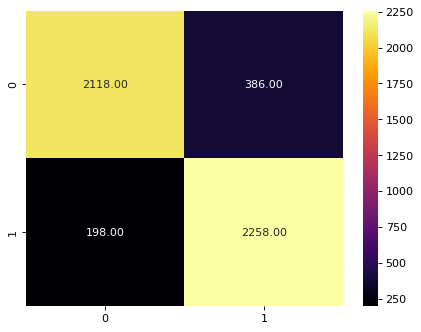

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

target_column = 'Loan_Approval_Status'

# Define and train the XGBoost model with the best parameters (model 4)
model_4 = xgb.XGBClassifier(**best_params)  # Assuming best_params contains your hyperparameters
train_features = train_df.drop(columns=[target_column])
train_target = train_df[target_column]
model_4.fit(train_features, train_target)

# Prepare test data and make predictions
test_features = test_df.drop(columns=[target_column])
y_test_4 = test_df[target_column]
y_pred_4 = model_4.predict(test_features)
y_prob_4 = model_4.predict_proba(test_features)

# Evaluate the model using a custom metric calculator
metric_calculator(y_test_4, y_pred_4, y_prob=y_prob_4)

# Generate and display the confusion matrix
cf_matrix = confusion_matrix(y_test_4, y_pred_4)
sns.heatmap(cf_matrix, annot=True, fmt='.2f', cmap='inferno')


# **Model 6: LightGBM**

In [ ]:
target_column = 'Loan_Approval_Status'

# Function to train and evaluate the model
def train_and_evaluate(model, train_df, valid_df, target_column):
    # Training the model
    model.fit(train_df.drop(columns=[target_column]), train_df[target_column])

    # Predictions and probabilities for train and validation sets
    y_pred_train = model.predict(train_df.drop(columns=[target_column]))
    y_prob_train = model.predict_proba(train_df.drop(columns=[target_column]))[:, 1]

    y_pred_valid = model.predict(valid_df.drop(columns=[target_column]))
    y_prob_valid = model.predict_proba(valid_df.drop(columns=[target_column]))[:, 1]

    # Calculating metrics
    train_accuracy = accuracy_score(train_df[target_column], y_pred_train)
    train_roc_auc = roc_auc_score(train_df[target_column], y_prob_train)

    valid_accuracy = accuracy_score(valid_df[target_column], y_pred_valid)
    valid_roc_auc = roc_auc_score(valid_df[target_column], y_prob_valid)

    train_results = {'Accuracy': train_accuracy, 'ROC-AUC': train_roc_auc}
    valid_results = {'Accuracy': valid_accuracy, 'ROC-AUC': valid_roc_auc}

    return train_results, valid_results

# Define the LightGBM model
model_lgb = lgb.LGBMClassifier(n_estimators=100, max_depth=10, random_state=42)  # LightGBM model

# Train the LightGBM model and print the results
train_results, valid_results = train_and_evaluate(model_lgb, train_df, valid_df, target_column)

print("Train results:")
print(train_results)
print("---" * 15)
print("Test results:")
print(valid_results)



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 11572, number of negative: 11572
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2302
[LightGBM] [Info] Number of data points in the train set: 23144, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_le

# **Hyperparameter Tuning For LightGBM**

In [ ]:
# Define the LightGBM model
model_lgb = lgb.LGBMClassifier(random_state=42)

# Define a reduced parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'learning_rate': [0.01, 0.1],
}

# Define the scoring metric (you can use a different metric as needed)
scoring = make_scorer(roc_auc_score)

# Create GridSearchCV object with fewer cross-validation folds
grid_search = GridSearchCV(estimator=model_lgb, param_grid=param_grid, scoring=scoring, cv=3, verbose=2)

# Train and evaluate the tuned model
grid_search.fit(train_df.drop(columns=[target_column]), train_df[target_column])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best ROC AUC Score: ", grid_search.best_score_)

# Get the best model
best_model_lgb = grid_search.best_estimator_

# Train and evaluate the best model
train_results, valid_results = train_and_evaluate(best_model_lgb, train_df, valid_df, target_column)

print("Train results:")
print(train_results)
print("---" * 15)
print("Test results:")
print(valid_results)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7714, number of negative: 7715
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2302
[LightGBM] [Info] Number of data points in the train set: 15429, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499968 -> initscore=-0.000130
[LightGBM] [Info] Start training from score -0.000130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

# **LightGBM After Tuning**

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 11572, number of negative: 11572
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2302
[LightGBM] [Info] Number of data points in the train set: 23144, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_le

<Axes: >

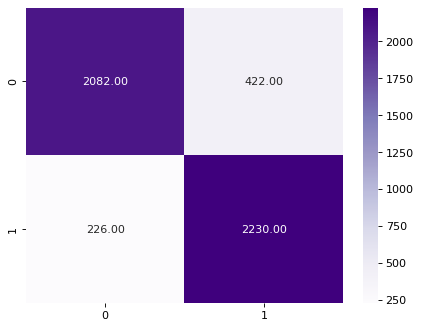

In [ ]:
# Assuming best_params contains your hyperparameters from the hyperparameter tuning step
best_params = grid_search.best_params_

# Define and train the LightGBM model with the best parameters
model_lgb = lgb.LGBMClassifier(**best_params)
train_features = train_df.drop(columns=[target_column])
train_target = train_df[target_column]
model_lgb.fit(train_features, train_target)

# Prepare test data and make predictions
test_features = test_df.drop(columns=[target_column])
y_test_lgb = test_df[target_column]
y_pred_lgb = model_lgb.predict(test_features)
y_prob_lgb = model_lgb.predict_proba(test_features)[:, 1]

# Evaluate the model using a custom metric calculator
metric_calculator(y_test_lgb, y_pred_lgb, y_prob=y_prob_lgb)

# Generate and display the confusion matrix
cf_matrix = confusion_matrix(y_test_lgb, y_pred_lgb)
sns.heatmap(cf_matrix, annot=True, fmt='.2f', cmap='Purples')


## **Model 7: CatBoost**

In [ ]:
target_column = 'Loan_Approval_Status'

# Prepare the feature and target data
X_train = train_df.drop(columns=[target_column])
y_train = train_df[target_column]
X_valid = valid_df.drop(columns=[target_column])
y_valid = valid_df[target_column]

# Define the model
model_1 = CatBoostClassifier(depth=10, iterations=100, learning_rate=0.1, loss_function='Logloss', verbose=False, random_seed=42)

# Train the model
model_1.fit(X_train, y_train)

# Predictions on train and validation sets
y_pred_train_1 = model_1.predict(X_train)
y_prob_train_1 = model_1.predict_proba(X_train)
y_pred_valid_1 = model_1.predict(X_valid)
y_prob_valid_1 = model_1.predict_proba(X_valid)

# Evaluate and print results
print("Train results:")
print(metric_calculator(y_train, y_pred_train_1, y_prob=y_prob_train_1))
print("---" * 45)
print("Validation results:")
print(metric_calculator(y_valid, y_pred_valid_1, y_prob=y_prob_valid_1))

Train results:
Accuracy classification score: 0.9322070515036295
Precision score: 0.9081857504284665
Recall score: 0.9081857504284665
F1 score: 0.9341448058761805
None
---------------------------------------------------------------------------------------------------------------------------------------
Validation results:
Accuracy classification score: 0.8709677419354839
Precision score: 0.851963746223565
Recall score: 0.851963746223565
F1 score: 0.8757763975155279
None


# **Solving Overfitting for Catboost**

In [ ]:
# Define the Ridge classifier model
ridge_model = RidgeClassifier(alpha=1.0, random_state=42)

# Train the model
ridge_model.fit(X_train, y_train)

# Predictions on train and validation sets
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_valid_ridge = ridge_model.predict(X_valid)

# Train results
print("Train results:")
print(classification_report(y_train, y_pred_train_ridge))
print("Train accuracy:", accuracy_score(y_train, y_pred_train_ridge))

# Validation results
print("---" * 45)
print("Validation results:")
print(classification_report(y_valid, y_pred_valid_ridge))
print("Validation accuracy:", accuracy_score(y_valid, y_pred_valid_ridge))

Train results:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81     11572
           1       0.80      0.84      0.82     11572

    accuracy                           0.82     23144
   macro avg       0.82      0.82      0.82     23144
weighted avg       0.82      0.82      0.82     23144

Train accuracy: 0.8187003110957484
---------------------------------------------------------------------------------------------------------------------------------------
Validation results:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      2456
           1       0.81      0.84      0.83      2504

    accuracy                           0.82      4960
   macro avg       0.82      0.82      0.82      4960
weighted avg       0.82      0.82      0.82      4960

Validation accuracy: 0.8211693548387097


## **Ridge Plot**

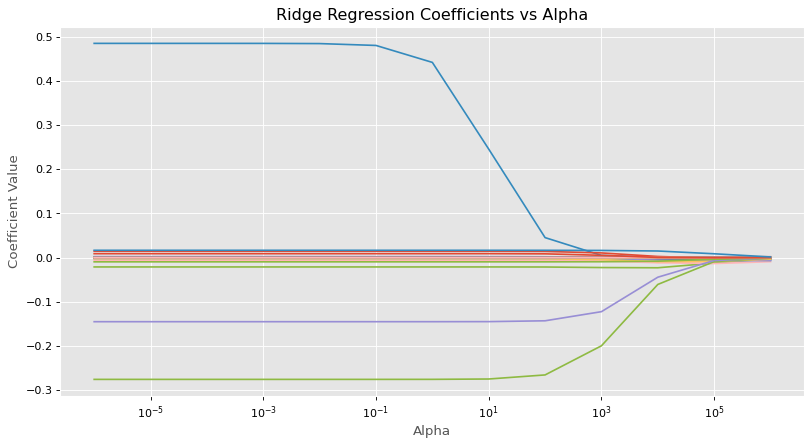

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

# Define a range of alpha values
alphas = np.logspace(-6, 6, 13)

# Initialize an array to store coefficients for each alpha
coefs = []

# Iterate over different alpha values
for alpha in alphas:
    # Create and fit Ridge model
    ridge_model = Ridge(alpha=alpha, random_state=42)
    ridge_model.fit(X_train, y_train)

    # Store coefficients for this alpha
    coefs.append(ridge_model.coef_)

# Plot the coefficients for each feature
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficient Value')
plt.title('Ridge Regression Coefficients vs Alpha')
plt.axis('tight')
plt.show()


# **ROC & PR-ROC Curves**

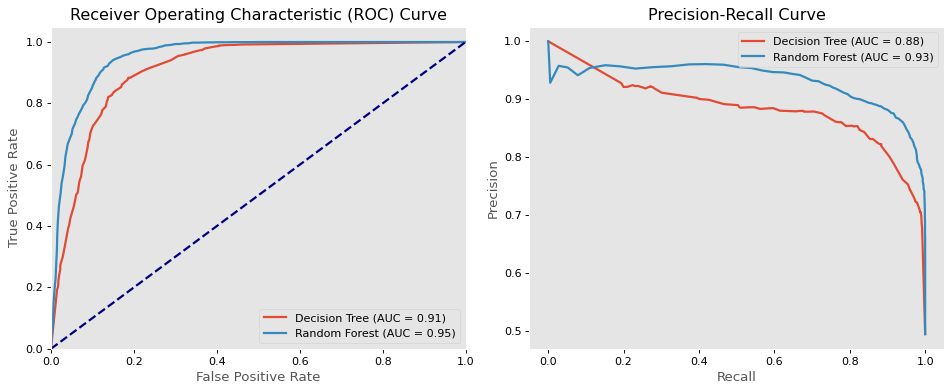

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

model_probabilities = {
    'Decision Tree': y_prob,
    'Random Forest': y_prob_2
}

# Call the function
plot_metrics_multi_models(y_test, model_probabilities)

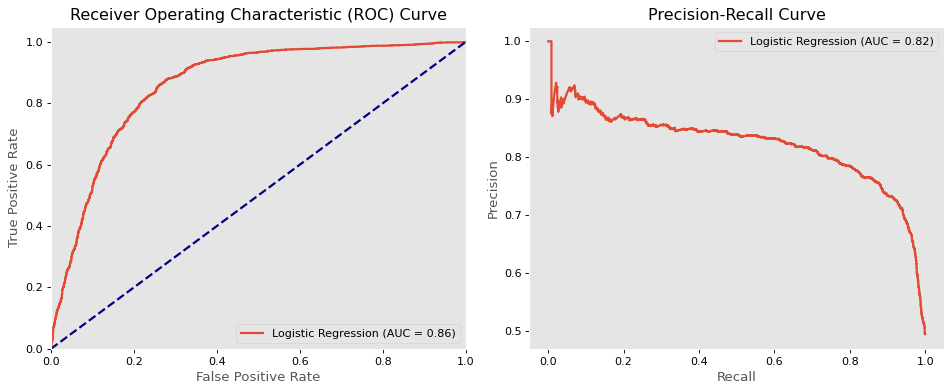

In [ ]:
model_probabilities = {
    'Logistic Regression': y_prob_3
}
# Call the function
plot_metrics_multi_models(y_test, model_probabilities)